In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/Chicago/Food_data.csv'
utils_dir = '/content/drive/My Drive/Chicago'

import sys
sys.path.append(utils_dir)
from utils import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
from shapely.geometry import Point
import shapely

In [67]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier


## Data preprocessing

In [5]:
data = pd.read_csv(data_path)

In [6]:
data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2571281,AFC SUSHI @ JEWEL OSCO #3349,AFC SUSHI @ JEWEL OSCO #3349,2841387.0,Shared Kitchen User (Long Term),Risk 1 (High),16915 N HAAS AVE,TORRANCE,CA,90504.0,02/15/2023,Canvass,Pass,NaN,NaN,NaN,NaN
1,2569647,Sauganash Elementary School,Sauganash Elementary School,25211.0,School,Risk 1 (High),6040 N Kilpatrick (4700W) AVE,CHICAGO,IL,60646.0,01/13/2023,Canvass,Pass,NaN,NaN,NaN,NaN
2,2569445,JERSEY MIKES,JERSEY MIKE'S,2886344.0,Restaurant,Risk 1 (High),6153 N BROADWAY,CHICAGO,IL,60660.0,01/10/2023,License,Not Ready,NaN,41.993854,-87.660239,"(41.99385357489393, -87.66023863563797)"
3,2568003,HOT DOG EXPRESS,HOT DOG EXPRESS (T2 E5),1909525.0,Restaurant,Risk 2 (Medium),11601 W TOUHY AVE,CHICAGO,IL,60666.0,12/05/2022,Canvass,Pass,NaN,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)"
4,2567972,SBARRO,SBARRO,2882176.0,Restaurant,Risk 1 (High),500 W MADISON ST,CHICAGO,IL,60661.0,12/05/2022,License,Not Ready,NaN,41.881994,-87.639759,"(41.88199433820508, -87.6397586848809)"


The dataset contains the following columns:
1. Inspection ID: An identifier for the inspection
2. DBA Name: The name of the establishment
3. AKA Name: An alternate name for the establishment
4. License #: The license number of the establishment
5. Facility Type: The type of facility
6. Risk: The perceived risk level of the establishment
7. Address: The address of the establishment
8. City: The city in which the establishment is located
9. State: The state in which the establishment is located
10. Zip: The ZIP code of the establishment
11. Inspection Date: The date of the inspection
12. Inspection Type: The type of inspection conducted
13. Results: The result of the inspection (our target variable)
14. Violations: A description of any violations found during the inspection
15. Latitude: The latitude of the establishment
16. Longitude: The longitude of the establishment
17. Location: The combined latitude and longitude of the establishment

In [7]:
print(f"Shape of the dataframe: {data.shape}")

print("\nData types for each column:")
print(data.dtypes)

print("\nNumber of missing values for each column:")
print(data.isnull().sum())

Shape of the dataframe: (256789, 17)

Data types for each column:
Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Results             object
Violations          object
Latitude           float64
Longitude          float64
Location            object
dtype: object

Number of missing values for each column:
Inspection ID          0
DBA Name               0
AKA Name            2483
License #              8
Facility Type       5074
Risk                  79
Address                0
City                 187
State                 53
Zip                   85
Inspection Date        0
Inspection Type        1
Results                0
Violations         70056
Latitude             878
Longitude            878
Location          

Text(0.5, 1.0, 'Counts of missing values')

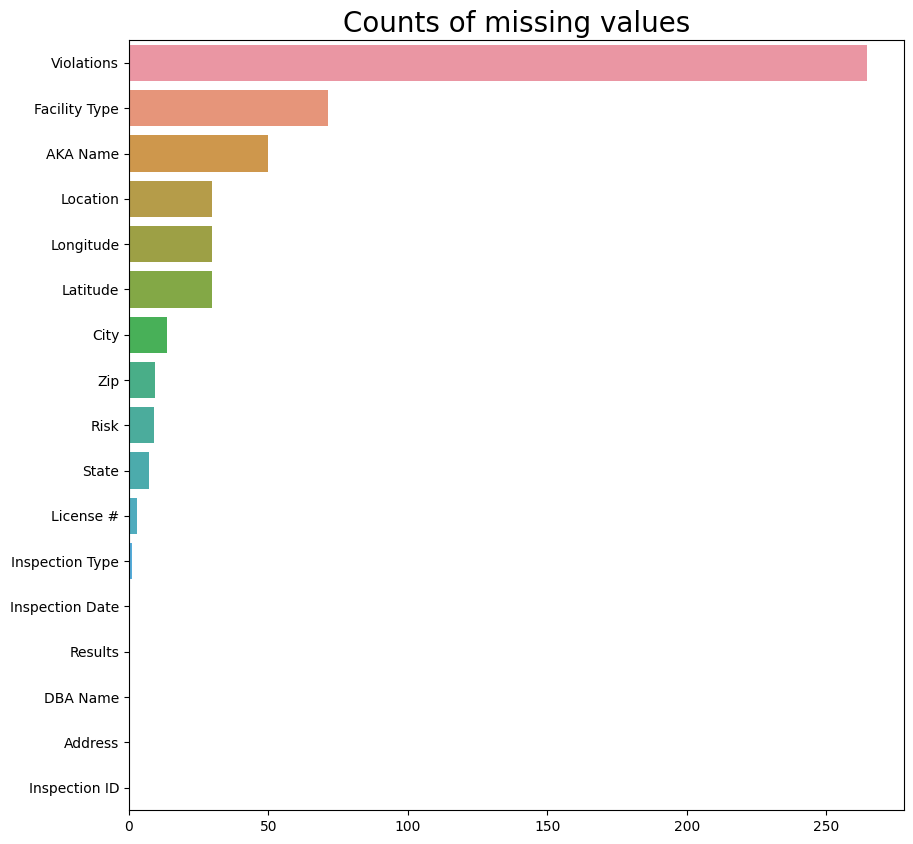

In [8]:
plt.figure(figsize=(10,10))
sns.barplot(x=np.sqrt(data.isnull().sum().sort_values(ascending=False)),y=data.isnull().sum().sort_values(ascending=False).index)
plt.title("Counts of missing values",size=20)

data[

## License #

License number: This is a unique number assigned to the establishment for the
purposes of licensing by the Department of Business Affairs and Consumer Protection.

Let's investigate License #

In [9]:
unique_values = data['License #'].nunique()

null_values = data['License #'].isnull().sum()

license_zero = data[data['License #'] == 0].shape[0]
license_999999 = data[data['License #'] == 999999].shape[0]

unique_values, null_values, license_zero, license_999999

(43524, 8, 670, 2)

The License # column has:

43,524 unique values
8 missing (null) values
670 records with a license number of 0
2 records with a license number of 999999
It appears that the license numbers 0 and 999999 are possibly placeholder or erroneous entries, as they are unlikely to be valid license numbers. Similarly, missing values may also represent a lack of information or data entry errors.

I will drop NaN License # values

In [10]:
data.dropna(subset = 'License #', axis = 0, inplace = True)

Now I will drop 0 and 999999 License numbers

In [11]:
data = data[(data['License #'] != 0) & (data['License #'] != 999999)]

data.shape

(256109, 17)

## Facility type

In [12]:
facility_types = data['Facility Type'].value_counts()

facility_types

Restaurant                               172170
Grocery Store                             32179
School                                    16169
Children's Services Facility               5212
Bakery                                     3713
                                          ...  
BOOK STORE                                    1
Pop-Up Food Establishment User-Tier I         1
CAT/LIQUOR                                    1
MOBILE DESSERT CART                           1
Kids Cafe'                                    1
Name: Facility Type, Length: 483, dtype: int64

The 'Facility Type' column contains 512 unique categories. The top five most frequent facility types are:

Restaurant: 172,328 instances
Grocery Store: 32,203 instances
School: 16,205 instances
Children's Services Facility: 5,212 instances
Bakery: 3,719 instances
On the other hand, there are facility types that only appear once in the data, such as 'CAR WASH', 'BOOK STORE', 'CAT/LIQUOR', 'ART CENTER', and 'Kids Cafe''.

In [13]:
missing_values = data['Facility Type'].isnull().sum()
missing_values

5013

In [14]:
data['Facility Type'].fillna('Unknown', inplace=True)

## Risk

Risk category of facility: Each establishment is categorized as to its risk of adversely
affecting the public’s health, with 1 being the highest and 3 the lowest. The frequency of
inspection is tied to this risk, with risk 1 establishments inspected most frequently and
risk 3 least frequently.

In [15]:
risk_values = data['Risk'].value_counts()

risk_values

Risk 1 (High)      186781
Risk 2 (Medium)     47971
Risk 3 (Low)        21257
All                    53
Name: Risk, dtype: int64

The 'Risk' column has four unique categories:

'Risk 1 (High)': 187,115 instances
'Risk 2 (Medium)': 48,209 instances
'Risk 3 (Low)': 21,329 instances
'All': 57 instances
Now, let's examine the missing values in this column.

In [16]:
data = data[data['Risk'] != 'All']

In [17]:
data['Risk'].fillna('Unknown', inplace=True)
data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2571281,AFC SUSHI @ JEWEL OSCO #3349,AFC SUSHI @ JEWEL OSCO #3349,2841387.0,Shared Kitchen User (Long Term),Risk 1 (High),16915 N HAAS AVE,TORRANCE,CA,90504.0,02/15/2023,Canvass,Pass,NaN,NaN,NaN,NaN
1,2569647,Sauganash Elementary School,Sauganash Elementary School,25211.0,School,Risk 1 (High),6040 N Kilpatrick (4700W) AVE,CHICAGO,IL,60646.0,01/13/2023,Canvass,Pass,NaN,NaN,NaN,NaN
2,2569445,JERSEY MIKES,JERSEY MIKE'S,2886344.0,Restaurant,Risk 1 (High),6153 N BROADWAY,CHICAGO,IL,60660.0,01/10/2023,License,Not Ready,NaN,41.993854,-87.660239,"(41.99385357489393, -87.66023863563797)"
3,2568003,HOT DOG EXPRESS,HOT DOG EXPRESS (T2 E5),1909525.0,Restaurant,Risk 2 (Medium),11601 W TOUHY AVE,CHICAGO,IL,60666.0,12/05/2022,Canvass,Pass,NaN,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)"
4,2567972,SBARRO,SBARRO,2882176.0,Restaurant,Risk 1 (High),500 W MADISON ST,CHICAGO,IL,60661.0,12/05/2022,License,Not Ready,NaN,41.881994,-87.639759,"(41.88199433820508, -87.6397586848809)"


## Inspection type

In [18]:
data['Inspection Type'].unique()

array(['Canvass', 'License', 'Non-Inspection', 'Canvass Re-Inspection',
       'Complaint', 'License Re-Inspection', 'Short Form Complaint',
       'Complaint Re-Inspection', 'Recent Inspection',
       'Suspected Food Poisoning',
       'Suspected Food Poisoning Re-inspection', 'Not Ready',
       'Consultation', 'Task Force Liquor 1475', 'Complaint-Fire',
       'Short Form Fire-Complaint', 'OUT OF BUSINESS', 'NO ENTRY',
       'License-Task Force', 'Tag Removal', 'Out of Business', 'No Entry',
       'out ofbusiness', 'COVID COMPLAINT', 'Recent inspection',
       'fire complaint', 'FIRE', nan, 'Special Events (Festivals)',
       'Complaint-Fire Re-inspection', 'KITCHEN CLOSED FOR RENOVATION',
       'CORRECTIVE ACTION', 'O.B.', 'LICENSE CANCELED BY OWNER',
       'LICENSE CONSULTATION', 'License consultation',
       'Package Liquor 1474', 'No entry', 'CANVASS SPECIAL EVENTS',
       'TWO PEOPLE ATE AND GOT SICK.', 'CANVASS SCHOOL/SPECIAL EVENT',
       'Pre-License Consultation',

Looking at `Inspection Type` values we can see that they need some cleaning. According to the [document describing the dataset](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) we should have following inspection types:
 - **canvass**: regular inspections with frequency depending on establishment risk,
 - **complaint**: in a response to filed complaint,
 - **license**: when obtaining a license, as a requirement of launching the establishment (should be once for most or more if they failed, this might be a separate study case),
 - **suspect food poisoning**: specific type of *complaint* when someone reports getting ill after eating from there
 - **task-force**: for bars and taverns.

Also, as the linked document states, re-inspections can be done for most of the types and are indicated in the name of inspection type.

First, we replace NaN values in Inspection Type with "Unknown":

In [19]:
data.fillna(value={'Inspection Type': 'Unknown'}, inplace=True)

Now, since we may want to use the indication whether a particular inspection was a re-inspection or not, we add a separate column that will indicate that:

In [20]:
inspection_types = data['Inspection Type'].unique().astype(str)

In [21]:
standardize_by_finding_keyword(data, inspection_types, ['canvas'], 'Canvass')
standardize_by_finding_keyword(data, inspection_types, ['complain'], 'Complaint')
standardize_by_finding_keyword(data, inspection_types, ['license'], 'License')
standardize_by_finding_keyword(data, inspection_types, ['task', 'liquor'], 'Task Force')

In [22]:
# Suspected Food Poisoning replacements
sfp_values = data['Inspection Type'].str.lower().str.contains('food|sfp', regex=True)
data.loc[sfp_values, 'Inspection Type'] = 'Suspected Food Poisoning'
standardize_by_finding_keyword(data, inspection_types, ['sick'], 'Suspected Food Poisoning')

In [23]:
data.groupby(by='Inspection Type')['Inspection ID'].count()

Inspection Type
ADDENDUM                               1
Business Not Located                   1
CHANGED COURT DATE                     1
CITF                                   1
CORRECTIVE ACTION                      1
Canvass                           161462
Complaint                          42634
Consultation                         659
Duplicated                             1
FIRE                                   1
HACCP QUESTIONAIRE                     1
Illegal Operation                      2
KITCHEN CLOSED FOR RENOVATION          1
Kids Cafe'                             1
License                            46030
NO ENTRY                               8
No Entry                              60
No entry                               1
Non-Inspection                      2275
Not Ready                             20
O.B.                                   1
OUT OF BUSINESS                       23
Out of Business                      284
POSSIBLE FBI                           1


There are still a lot of values that appear only once in the entire dataset. There are also ones that could be merged into single categories (e.g. "no entry", "out of business", "recent inspection"). We also decide to leave the categories with significant amount of records, such as "Consultation". The ones we decide to drop will be reclassified under "Unknown" category.

In [24]:
merge_categories(data, 'recent inspection', 'Recent Inspection')
merge_categories(data, 'out of business', 'Out of Business')
merge_categories(data, 'no entry', 'No Entry')

In [25]:
known_list = ['License', 'Canvass', 'Complaint', 'Consultation', 'No Entry', 'Out of Business', 'Recent Inspection', 'Suspected Food Poisoning', 'Tag Removal', 'Task Force']
# Classify the rest as unknown
data.loc[~data['Inspection Type'].isin(known_list), 'Inspection Type'] = 'Unknown'

In [26]:
data.groupby(by='Inspection Type')['Inspection ID'].count()

Inspection Type
Canvass                     161462
Complaint                    42634
Consultation                   659
License                      46030
No Entry                        73
Out of Business                307
Recent Inspection              443
Suspected Food Poisoning      1173
Tag Removal                    602
Task Force                     317
Unknown                       2356
Name: Inspection ID, dtype: int64

Additionally, let's propagate "Out of Business" indication to "Results" column where it should be indicated:

In [27]:
out_of_business = data[data['Inspection Type'] == 'Out of Business'].index
data.loc[out_of_business, 'Results'] = 'Out of Business'

## Handling Location based columns

We take the following preprocessing steps:
1. Making Licence # column a unique identifier in the dataset.
2. Fixing the zip codes by completing the missing values based on the values of Longitude and Latitude.
3. Fixing the City column by completing the missing values based on the zip code.
4. Standardizing the Inspection Type values by cleaning various namings and reducing the number of categories.
   

In [28]:
print(f"Using DBA Name we can see there are {data['DBA Name'].nunique()} distinct names")

Using DBA Name we can see there are 31305 distinct names


In [29]:
data = data[~((data['Longitude'].isna()) | (data['Latitude'].isna()))]

The big part of our analysis will be based on neighborhoods, therefore we will hugely rely on the Zip column.

In [30]:
print('There are {0} missing values for Zip column'.format(data[data['Zip'].isna()].shape[0]))
print('There are {0} missing values for City column'.format(data[data['City'].isna()].shape[0]))

There are 81 missing values for Zip column
There are 181 missing values for City column


We want to populate the missing Zip values based on the Latitude and Longitude. In order to do that, we must have those two features for all the restaurants in the dataset. That is why we decided to drop all entries where one of those features is missing.

In [31]:
zip_na = data[data['Zip'].isna()]

To populate Zip values based on coordinates, we use [shapely](https://pypi.org/project/Shapely/) - Python package for manipulation and analysis of planar geometric objects.

In [32]:
points = create_points(zip_na)

In [33]:
geojson_path = '/content/drive/My Drive/Chicago/chicago-zip.geojson'
zip_found = populate_missing_zip(points, geojson_path)
print('Total {0} point found matching Chicago sectors.'.format(len(zip_found)))

Total 81 point found matching Chicago sectors.


In [34]:
zip_found = pd.DataFrame(zip_found)
zip_found.drop_duplicates(inplace=True)

In [35]:
data = data.merge(zip_found,on=['Latitude','Longitude'], how='left',suffixes=('', '_notnull'))
data.Zip.fillna(value=data.Zip_notnull, inplace=True)
data.drop(columns=["Zip_notnull"], inplace=True)

In [36]:
print('There are {0} missing Zip left in the restaurant dataset.'.format(data[data.Zip.isnull()].shape[0]))

There are 0 missing Zip left in the restaurant dataset.


In [37]:
data['Zip']=data['Zip'].apply(lambda x: str(int(x)))

### Completing City column based on zip codes

In [38]:
chicago_zip = create_chicago_zip_list()

In [39]:
# Check if there is any restaurant not in Chicago
not_in_chicago = len(data[data.City.isna() & (~data.Zip.isin(chicago_zip))])
print('There are {0} Zip values which are not in Chicago.'.format(not_in_chicago))

There are 0 Zip values which are not in Chicago.


In [40]:
data.City.fillna(value='Chicago', inplace=True)

In [41]:
print('There are {0} missing City values left in the restaurant dataset.'.format(data[data.City.isnull()].shape[0]))

There are 0 missing City values left in the restaurant dataset.


In [42]:
data.City.unique()

array(['CHICAGO', 'Chicago', 'CHCHICAGO', 'chicago', 'CCHICAGO',
       'CHicago', 'CHICAGO.', 'CHICAGOCHICAGO', 'CHICAGOO', 'CHICAGOC',
       '312CHICAGO', 'chicagoBEDFORD PARK', 'CHCICAGO', 'CHARLES A HAYES',
       'LOMBARD', 'CHICAGOI', 'WESTMONT', 'SUMMIT', 'INACTIVE',
       'BLUE ISLAND'], dtype=object)

In [43]:
# Change all values for City column to be Chicago
data.City = 'Chicago'
data.City.unique()

array(['Chicago'], dtype=object)

### State

In [44]:
state_fill_value = data['State'].mode().iloc[0]
data['State'].fillna(state_fill_value, inplace=True)

In [45]:
data.isna().sum()

Inspection ID          0
DBA Name               0
AKA Name            2406
License #              0
Facility Type          0
Risk                   0
Address                0
City                   0
State                  0
Zip                    0
Inspection Date        0
Inspection Type        0
Results                0
Violations         69519
Latitude               0
Longitude              0
Location               0
dtype: int64

### AKA Name

• AKA: ‘Also known as.’ This is the name the public would know the establishment as.


In [46]:
data['AKA Name'] = data['AKA Name'].fillna(data['DBA Name'])

### Violations

Violations: An establishment can receive one or more of 45 distinct violations (violation
numbers 1-44 and 70). For each violation number listed for a given establishment, the
requirement the establishment must meet in order for it to NOT receive a violation is
noted, followed by a specific description of the findings that caused the violation to be
issed.

From this information we can see, that NaN values are No violations. I will replace them now

In [47]:
data['Violations'] = data['Violations'].fillna('No Violations')

In [48]:
data.isnull().sum()

Inspection ID      0
DBA Name           0
AKA Name           0
License #          0
Facility Type      0
Risk               0
Address            0
City               0
State              0
Zip                0
Inspection Date    0
Inspection Type    0
Results            0
Violations         0
Latitude           0
Longitude          0
Location           0
dtype: int64

Next, let's do some data visualizations to explore the data further. We can look at the distribution of inspections over time, the distribution of inspections by risk level, and the distribution of inspections by facility type. We can also plot the locations of the inspections on a map to see if there's any spatial pattern. As for feature engineering, we can create features based on location (e.g., distance to city center) and time (e.g., day of week, month, year).

### Data visualization

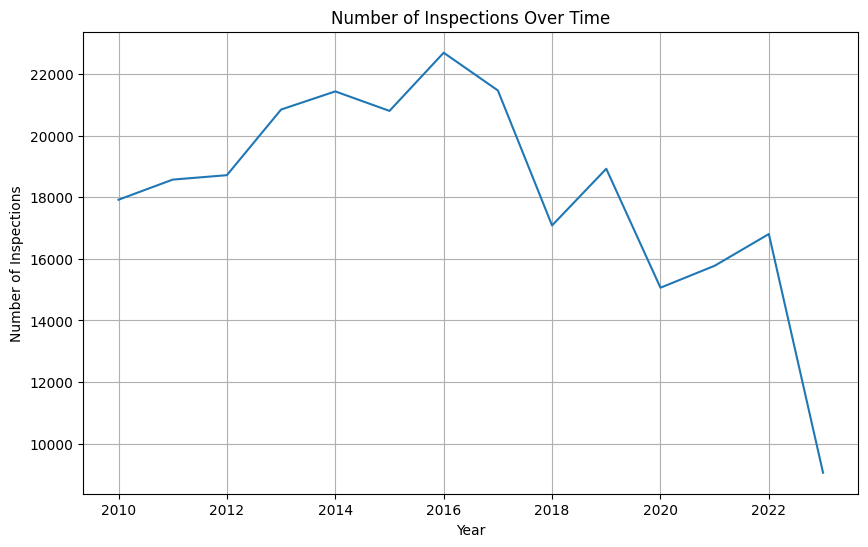

In [49]:
data['Inspection Date'] = pd.to_datetime(data['Inspection Date'])

# Create a new dataframe with inspection counts by year
data_yearly_counts = data['Inspection Date'].dt.year.value_counts().sort_index().reset_index()
data_yearly_counts.columns = ['Year', 'Count']

# Plot the number of inspections over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Count', data=data_yearly_counts)
plt.title('Number of Inspections Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Inspections')
plt.grid(True)
plt.show()

The line plot shows the trend in the number of inspections over time. We can see that there is a general increase in the number of inspections up to around 2019, after which there is a sharp decline. This could be due to a variety of factors, such as changes in regulation or inspection policies, or external events (like the COVID-19 pandemic).

Next, let's look at the distribution of inspections by risk level. This will give us an idea of the types of establishments that are being inspected.

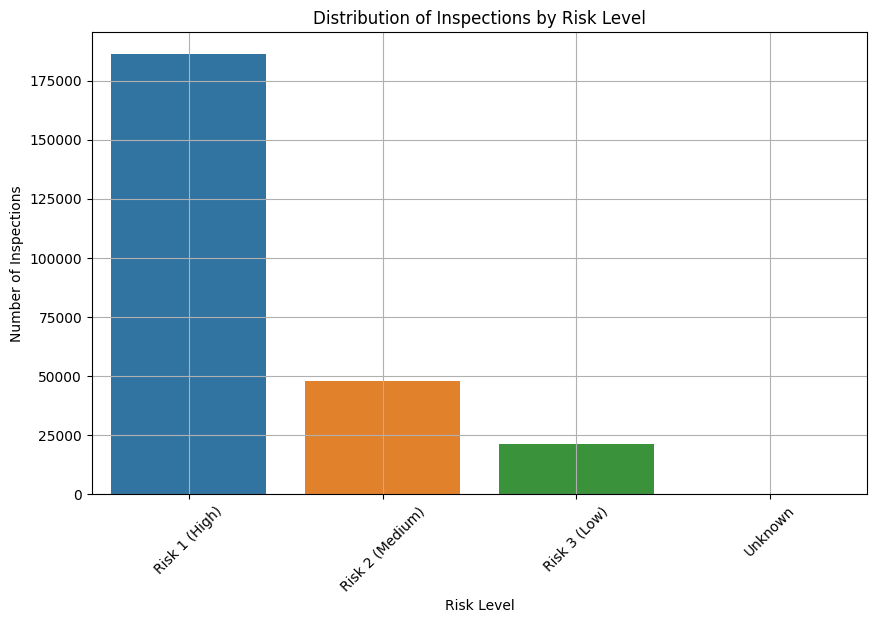

In [50]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Risk', order=data['Risk'].value_counts().index)
plt.title('Distribution of Inspections by Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('Number of Inspections')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

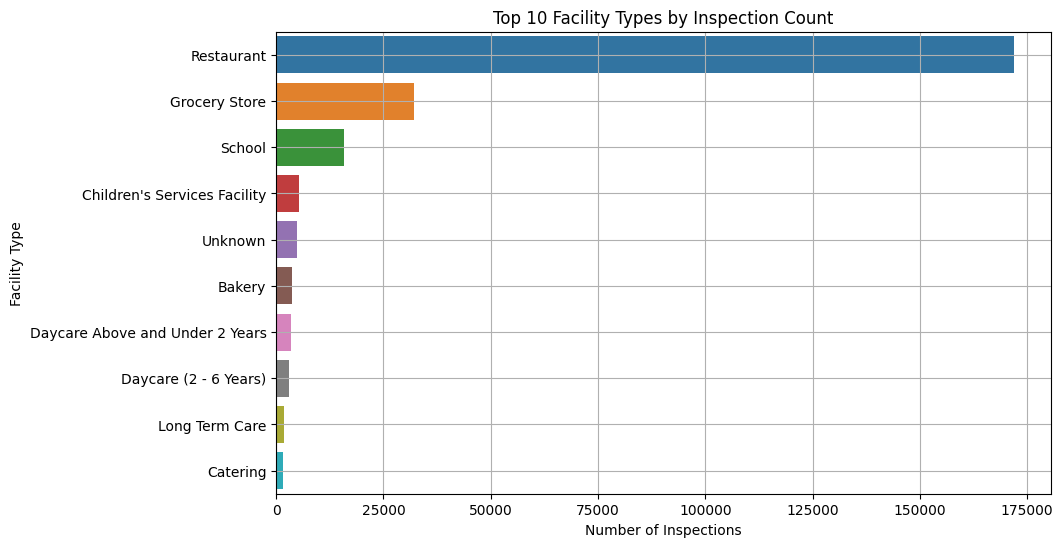

In [51]:
# Plot the distribution of inspections by facility type (top 10)
plt.figure(figsize=(10, 6))
sns.countplot(data=data, y='Facility Type',
              order=data['Facility Type'].value_counts().iloc[:10].index,
              orient='h')
plt.title('Top 10 Facility Types by Inspection Count')
plt.xlabel('Number of Inspections')
plt.ylabel('Facility Type')
plt.grid(True)
plt.show()

Now let's plot the locations of the inspections on a map to see if there's any spatial pattern. We'll use a scatter plot with the latitude and longitude of the establishments. Please note that for privacy and performance reasons, this won't be a full-featured geographic map, but it should give us a rough idea of the spatial distribution of the inspections.

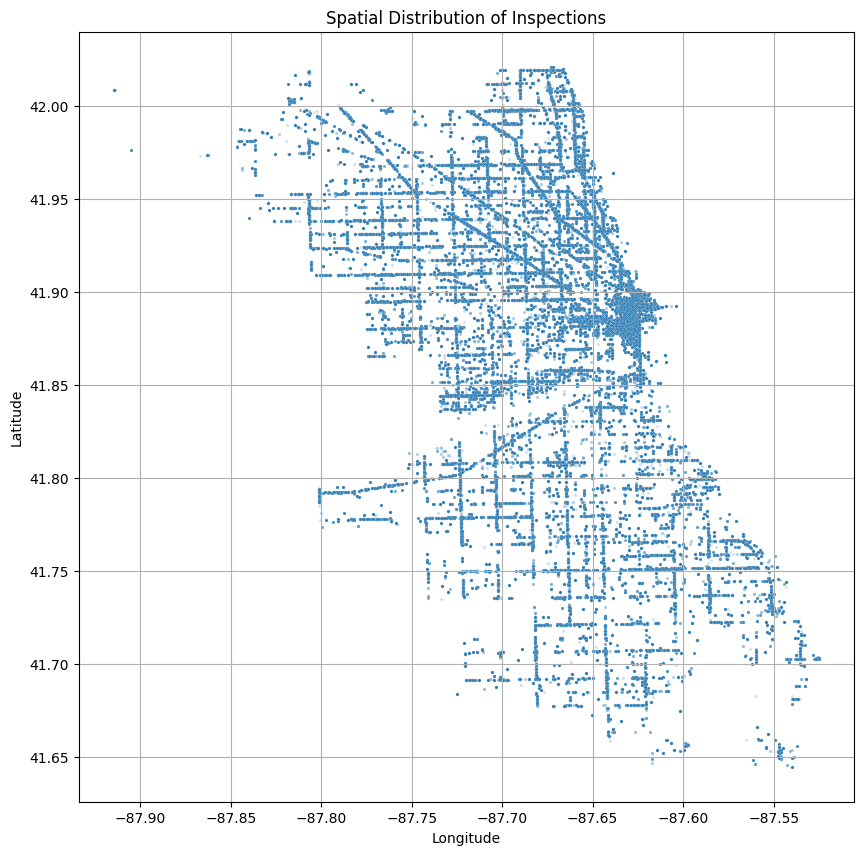

In [52]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=data, x='Longitude', y='Latitude', alpha=0.2, s=5)
plt.title('Spatial Distribution of Inspections')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

### Preparing Data for our model. Feature Engineering

In [53]:
data['Results'] = data['Results'].apply(lambda x: 'Pass' if x in ['Pass', 'Pass w/ Conditions'] else 'Fail')

data['Results'].value_counts()

Pass    170533
Fail     84652
Name: Results, dtype: int64

In [54]:
data.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [ ]:
data = pd.get_dummies(data, columns=['Risk'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

data['Violations'] = data['Violations'].astype(str)
data['Violation Codes'] = data['Violations'].apply(extract_violation_codes)
data['nb_violation'] = data['Violation Codes'].apply(lambda x: 0 if 0 in x else len(x))


reinspection_pattern = 're-inspec|reinspec|re inspec'
data['Re-inspection'] = data['Inspection Type'].str.lower().str.contains(reinspection_pattern, regex=True)
data['Re-inspection'] = data['Re-inspection'].map(lambda x: int(x))

le = LabelEncoder()
data['Violation Codes'] = le.fit_transform(data['Violation Codes'].astype(str))
data['Inspection Type'] = le.fit_transform(data['Inspection Type'].astype(str))

In [62]:
city_center = (41.881832, -87.623177)

data['Distance to City Center'] = calculate_distance(data['Latitude'], data['Longitude'], city_center)

data['Inspection Day of Week'] = data['Inspection Date'].dt.dayofweek
data['Inspection Month'] = data['Inspection Date'].dt.month
data['Inspection Year'] = data['Inspection Date'].dt.year
data['Zip'] = le.fit_transform(data['Zip'].astype(str))

In [70]:
categorical_features = ["Zip", "Inspection Type"]
data[categorical_features] = data[categorical_features].astype(str).apply(lambda col: le.fit_transform(col))

numerical_features = ["Violation Codes", "nb_violation", "Distance to City Center", "Inspection Month", "Inspection Year", ]
features = categorical_features + numerical_features

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(data[features], data['Results'])

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

I created some models to check our predictions

In [68]:
# Models
models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(),
    CalibratedClassifierCV(SGDClassifier(), method='sigmoid', cv=5),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss')
]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Let's see our feature importances

In [71]:
for model in models:
    print(f"Feature importance for {type(model).__name__}:")
    print(calculate_feature_importance(model, X_train, y_train))
    print("\n")


for model in models:
    cv_score, auc_roc = evaluate_model(model, X_train, y_train)
    print(f"{type(model).__name__}:")
    print(f"Cross-Validation AUC-ROC: {cv_score}")
    print(f"AUC-ROC: {auc_roc}\n")


Feature importance for LogisticRegression:
                    feature    importance
2           Violation Codes  2.897035e-01
3              nb_violation  5.803824e-02
1           Inspection Type  3.831687e-03
5          Inspection Month  1.475650e-03
0                       Zip  1.055195e-03
9         Risk_Risk 3 (Low)  1.036774e-04
6           Inspection Year  9.402754e-05
7        Risk_Risk 1 (High)  9.323095e-05
4   Distance to City Center  2.515691e-06
8      Risk_Risk 2 (Medium)  5.670044e-07
10             Risk_Unknown  1.449143e-08


Feature importance for RandomForestClassifier:
                    feature  importance
2           Violation Codes    0.256311
6           Inspection Year    0.092354
3              nb_violation    0.082221
1           Inspection Type    0.068547
4   Distance to City Center    0.042562
5          Inspection Month    0.036469
0                       Zip    0.030900
7        Risk_Risk 1 (High)    0.004277
9         Risk_Risk 3 (Low)    0.000897
8   

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier:
Cross-Validation AUC-ROC: 0.9355643524164406
AUC-ROC: 0.9434105563366041



From this info we see that Violation Codes are most important feature and Risk is literally unecessary

Now let's use gridsearch to find best params for our RandomForest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)

print("Best AUC-ROC score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_score = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

feature_importance = pd.DataFrame({'feature': X_train.columns,
                                   'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)
print("Feature importance for the best model:")
print(feature_importance)

selected_features = feature_importance[feature_importance['importance'] > 0]['feature']

X_train = X_train[selected_features]
X_test = X_test[selected_features]

best_model.fit(X_train, y_train)

print("AUC-ROC score for the best model with selected features: ", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

And let's check for overfitting

In [72]:
for model in models:
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)

    y_test_pred = model.predict(X_test_scaled)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Training set accuracy: {train_accuracy}")
    print(f"Test set accuracy: {test_accuracy}\n")

    if train_accuracy > test_accuracy:
        print(f"Model may be overfitting as training accuracy is significantly higher than test accuracy.\n")
    else:
        print(f"Model does not appear to be overfitting as training and test accuracies are comparable.\n")

Training set accuracy: 0.7622452313337187
Test set accuracy: 0.7617865519937451

Model may be overfitting as training accuracy is significantly higher than test accuracy.

Training set accuracy: 0.9944208489356889
Test set accuracy: 0.8959831899921814

Model may be overfitting as training accuracy is significantly higher than test accuracy.

Training set accuracy: 0.7618892044264616
Test set accuracy: 0.7616692728694292

Model may be overfitting as training accuracy is significantly higher than test accuracy.

Training set accuracy: 0.8640814924647953
Test set accuracy: 0.8553166536356529

Model may be overfitting as training accuracy is significantly higher than test accuracy.



Our **RandomForest** model is overfitting, other models are fine. The best one out of them is XGBoost.